In [1]:
import org.jetbrains.kotlinx.dl.dataset.preprocessing.fileLoader

import org.jetbrains.kotlinx.dl.api.core.Functional
import org.jetbrains.kotlinx.dl.api.core.SavingFormat
import org.jetbrains.kotlinx.dl.api.core.WritingMode
import org.jetbrains.kotlinx.dl.api.core.activation.Activations
import org.jetbrains.kotlinx.dl.api.core.initializer.GlorotUniform
import org.jetbrains.kotlinx.dl.api.core.layer.Layer
import org.jetbrains.kotlinx.dl.api.core.layer.core.Dense
import org.jetbrains.kotlinx.dl.api.core.layer.freeze
import org.jetbrains.kotlinx.dl.api.core.loss.Losses
import org.jetbrains.kotlinx.dl.api.core.metric.Metrics
import org.jetbrains.kotlinx.dl.api.core.optimizer.Adam
import org.jetbrains.kotlinx.dl.api.core.shape.TensorShape
import org.jetbrains.kotlinx.dl.api.inference.TensorFlowInferenceModel
import org.jetbrains.kotlinx.dl.api.inference.keras.loadWeights
import org.jetbrains.kotlinx.dl.api.inference.keras.loadWeightsForFrozenLayers
import org.jetbrains.kotlinx.dl.api.inference.keras.saveModelConfiguration
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModelHub
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModels
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModels.CV.Companion.createPreprocessing
import org.jetbrains.kotlinx.dl.api.preprocessing.pipeline
import org.jetbrains.kotlinx.dl.dataset.OnHeapDataset
import org.jetbrains.kotlinx.dl.dataset.embedded.dogsCatsSmallDatasetPath
import org.jetbrains.kotlinx.dl.dataset.embedded.fashionMnist
import org.jetbrains.kotlinx.dl.dataset.generator.FromFolders
import org.jetbrains.kotlinx.dl.impl.inference.imagerecognition.predictLabel
import org.jetbrains.kotlinx.dl.impl.inference.imagerecognition.predictProbabilities
import org.jetbrains.kotlinx.dl.impl.preprocessing.call
import org.jetbrains.kotlinx.dl.impl.preprocessing.image.*
import org.jetbrains.kotlinx.dl.impl.summary.logSummary
import java.awt.image.BufferedImage
import java.io.File
import javax.imageio.ImageIO
import examples.notebook.*

val EPOCHS = 3
val TRAINING_BATCH_SIZE = 8
val TEST_BATCH_SIZE = 16
val NUM_CLASSES = 2
val TRAIN_TEST_SPLIT_RATIO = 0.7

val imageRootDir = "/Users/urs/development/github/ai/kotlindl/notebook/cache/datasets"

In [2]:
val fileDataLoader = pipeline<BufferedImage>()
    .resize {
        outputHeight = 224
        outputHeight = 224
        interpolation = InterpolationType.BILINEAR
    }.convert { colorMode = ColorMode.BGR }
    .toFloatArray {  }
    .call(TFModels.CV.MobileNetV2().preprocessor)
    .fileLoader()


In [3]:
val originalModelHub = TFModelHub(cacheDirectory = File("cache/pretrainedModels"))
val originalModelType = TFModels.CV.MobileNetV2()
val originalModel = originalModelHub.loadModel(originalModelType)
val hdfFile = originalModelHub.loadWeights(originalModelType)

originalModel.apply {
    compile(
        optimizer = Adam(),
        loss = Losses.MAE,
        metric = Metrics.ACCURACY
    )

    loadWeights(hdfFile)
    logSummary()
}

13:50:04.220 [Execution of code 'val originalModelHub...'] INFO  org.jetbrains.kotlinx.dl.api.core.GraphTrainableModel - Starting loading weights...
13:50:04.266 [Execution of code 'val originalModelHub...'] DEBUG org.jetbrains.kotlinx.dl.api.core.GraphTrainableModel - 864 parameters loaded for the layer Conv1.
13:50:04.299 [Execution of code 'val originalModelHub...'] DEBUG org.jetbrains.kotlinx.dl.api.core.GraphTrainableModel - 128 parameters loaded for the layer bn_Conv1.
13:50:04.309 [Execution of code 'val originalModelHub...'] DEBUG org.jetbrains.kotlinx.dl.api.core.GraphTrainableModel - 288 parameters loaded for the layer expanded_conv_depthwise.
13:50:04.343 [Execution of code 'val originalModelHub...'] DEBUG org.jetbrains.kotlinx.dl.api.core.GraphTrainableModel - 128 parameters loaded for the layer expanded_conv_depthwise_BN.
13:50:04.354 [Execution of code 'val originalModelHub...'] DEBUG org.jetbrains.kotlinx.dl.api.core.GraphTrainableModel - 512 parameters loaded for the la

GraphTrainableModel(numberOfLayers=157) TrainableModel(numberOfClasses=1000) org.jetbrains.kotlinx.dl.api.core.Functional@9949ef5

,jay,Accuracy: 0.87012255
,scorpion,Accuracy: 0.992853
,"piggy bank, penny bank",Accuracy: 0.99923825
,typewriter keyboard,Accuracy: 0.24544305
,obelisk,Accuracy: 0.615111
,minivan,Accuracy: 0.6914435
,macaw,Accuracy: 0.81449527
,"tabby, tabby cat",Accuracy: 0.96976376
,"Scotch terrier, Scottish terrier, Scottie",Accuracy: 0.37077984
,"bell cote, bell cot",Accuracy: 0.32443377

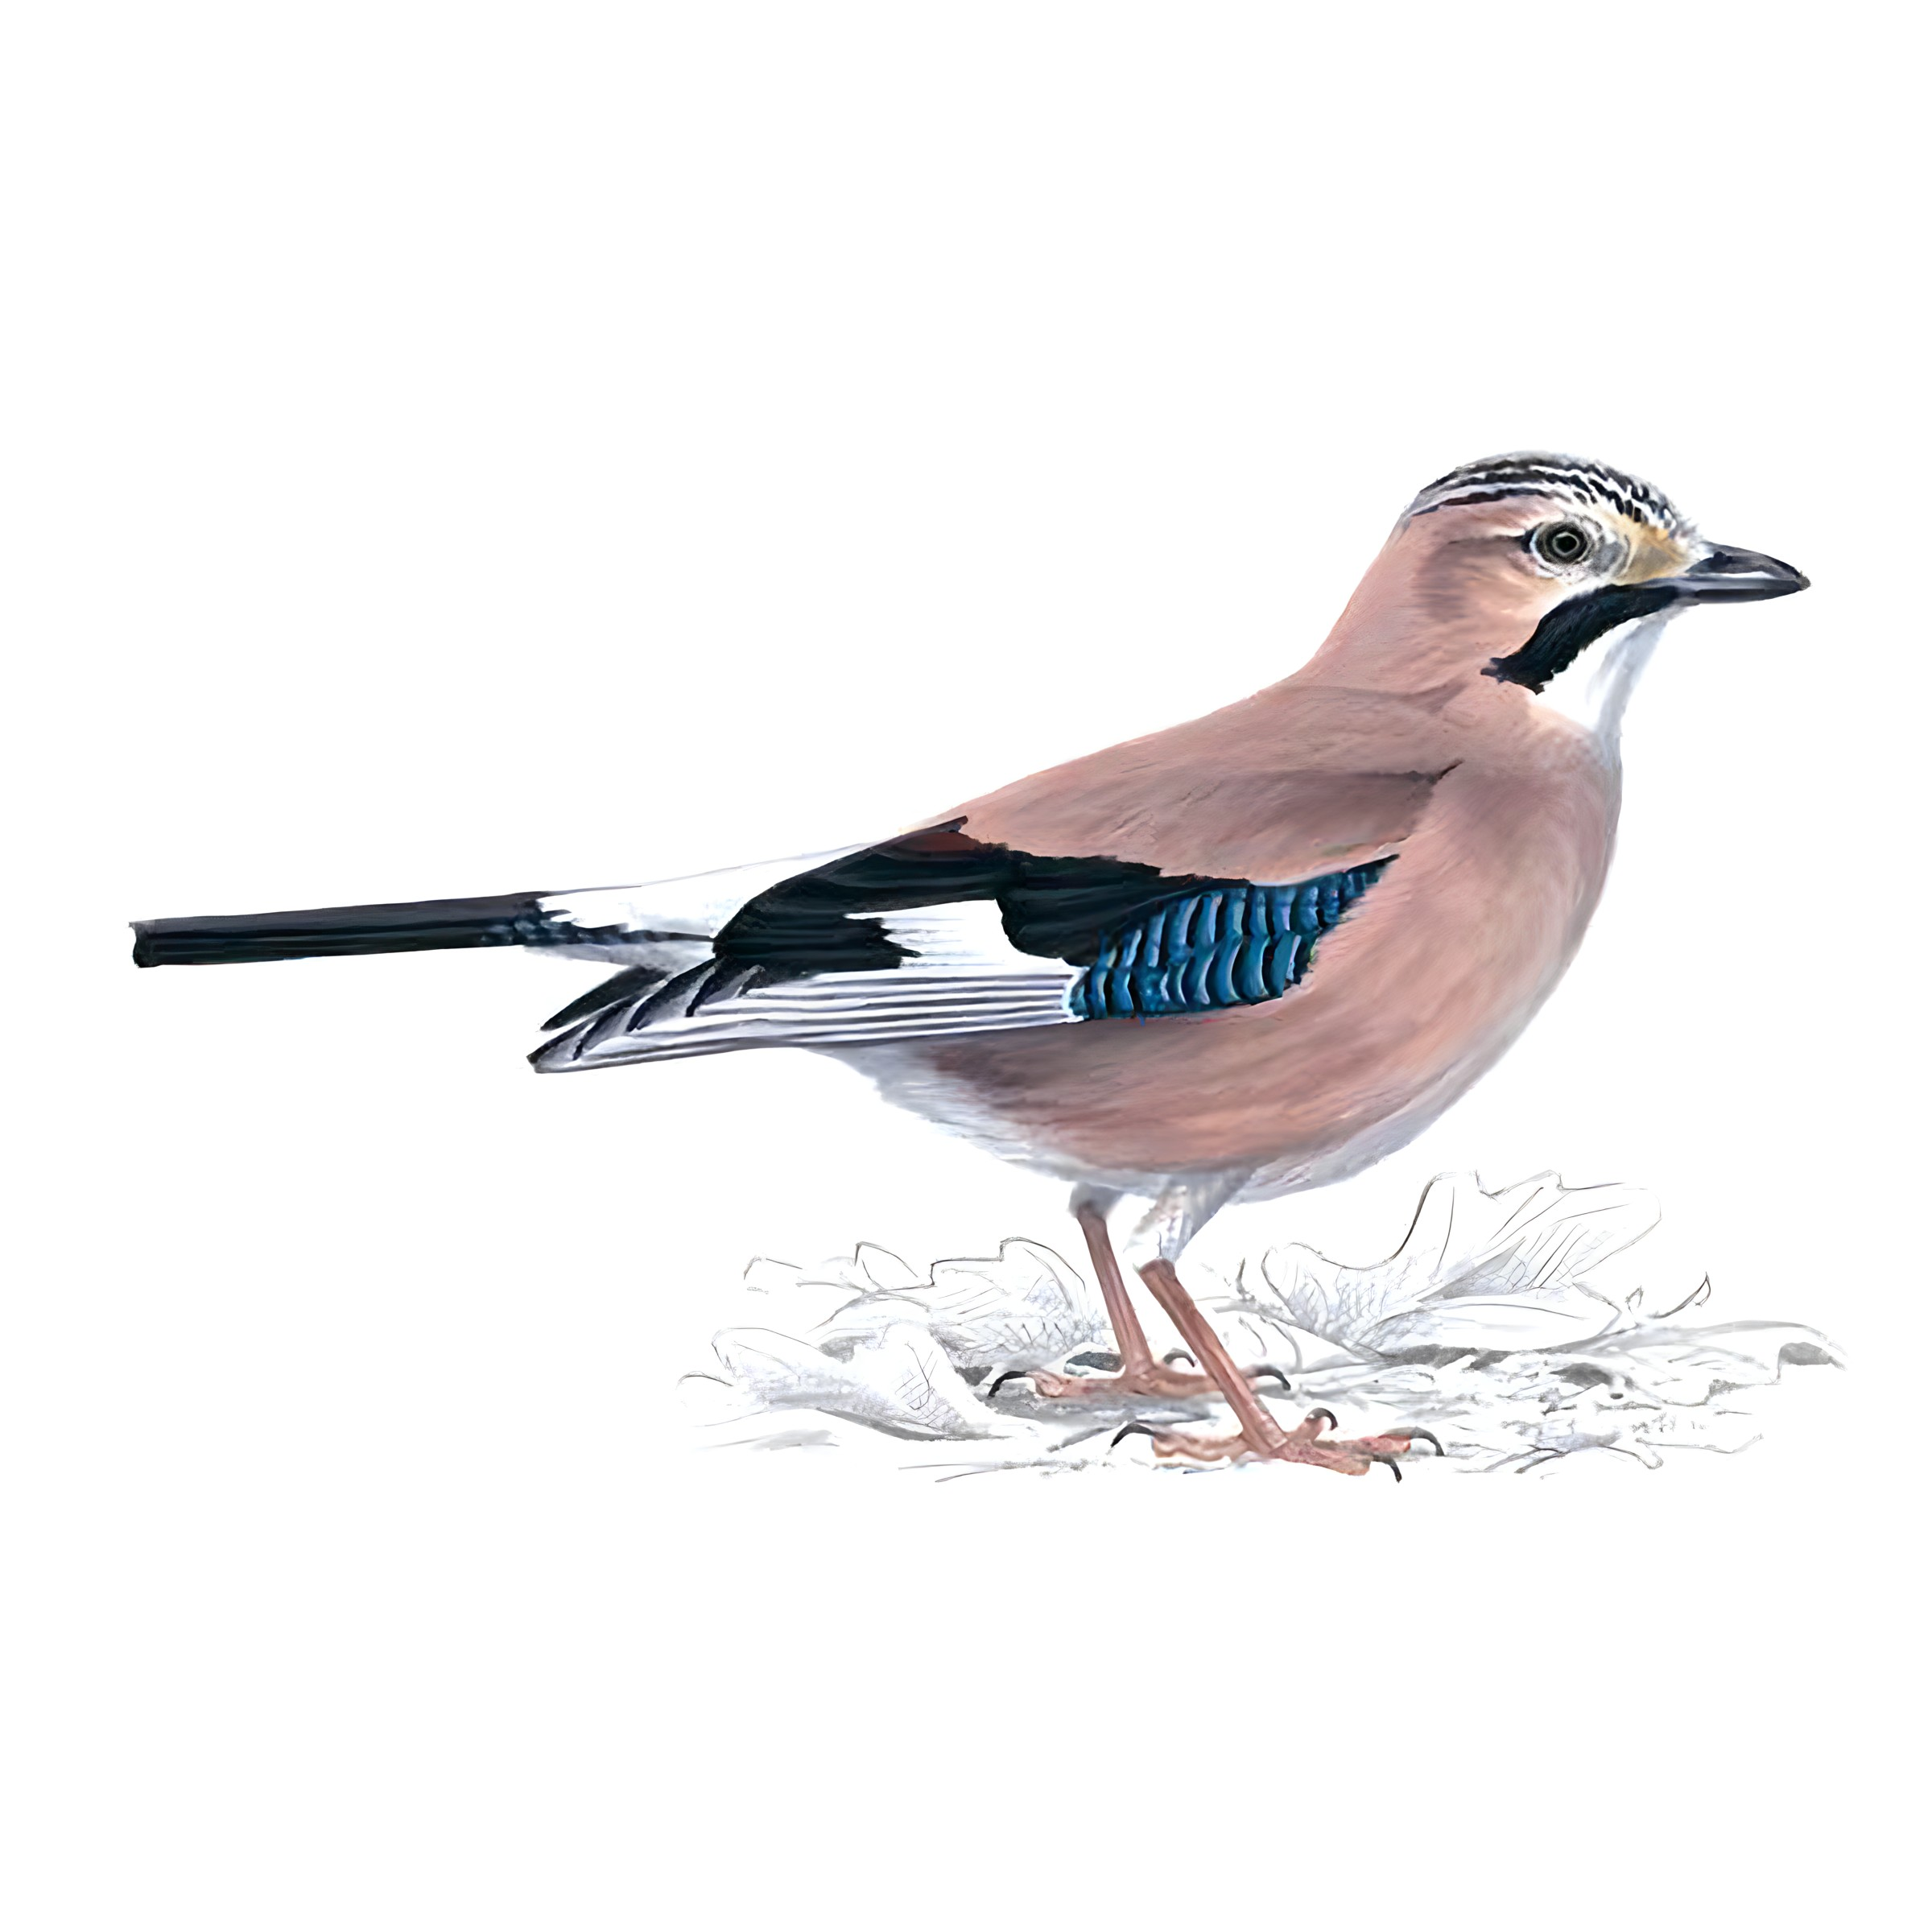
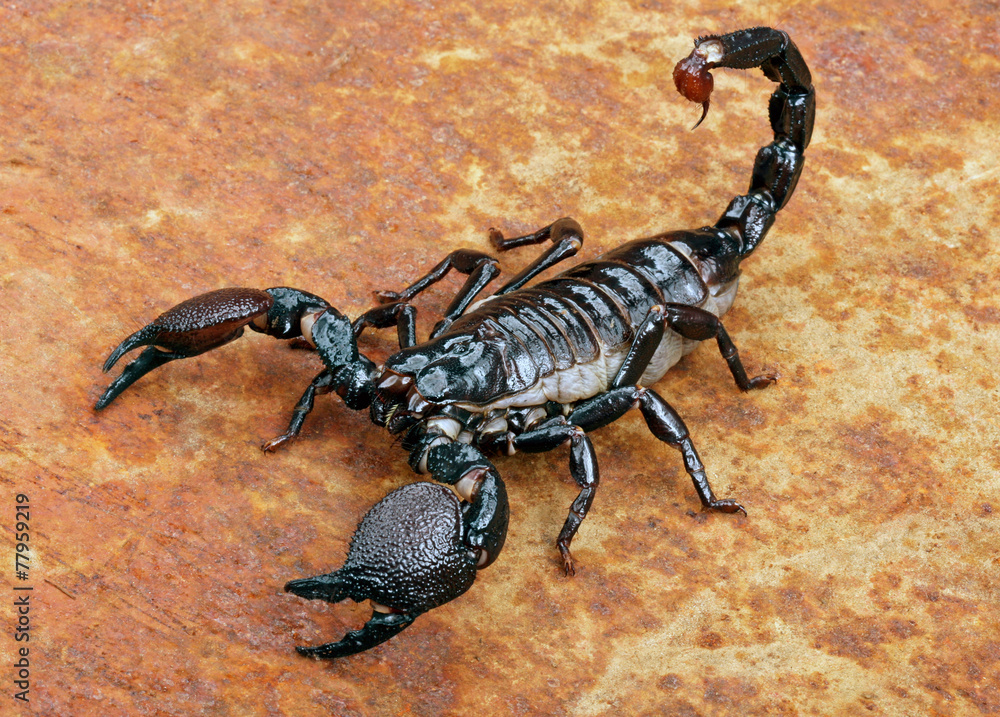
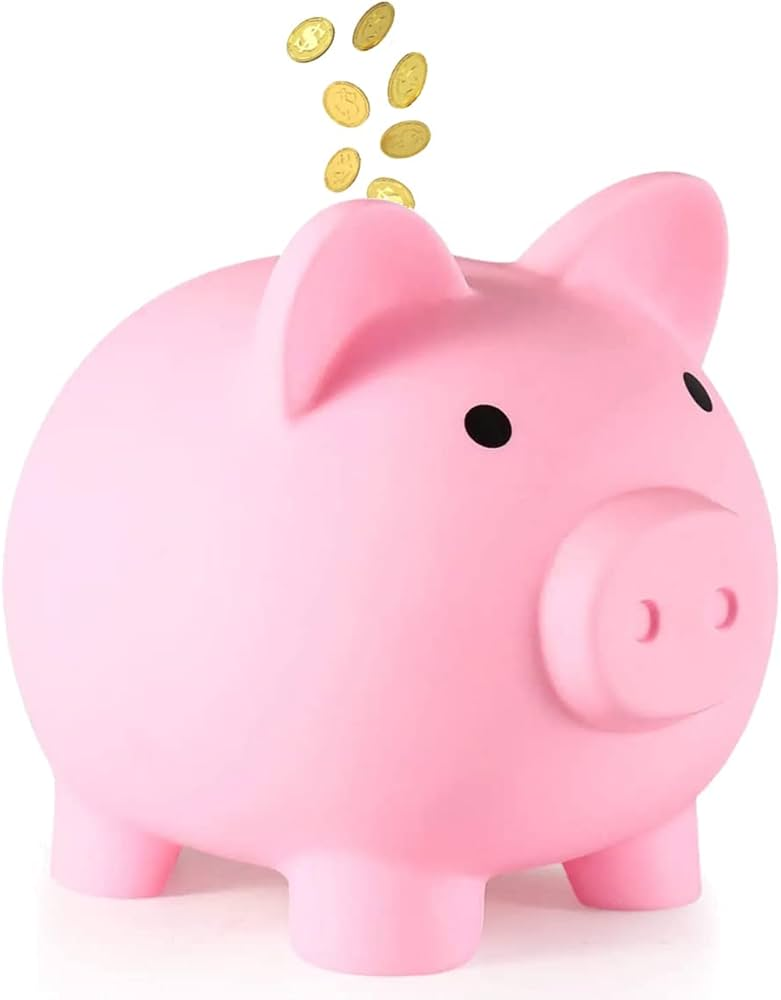
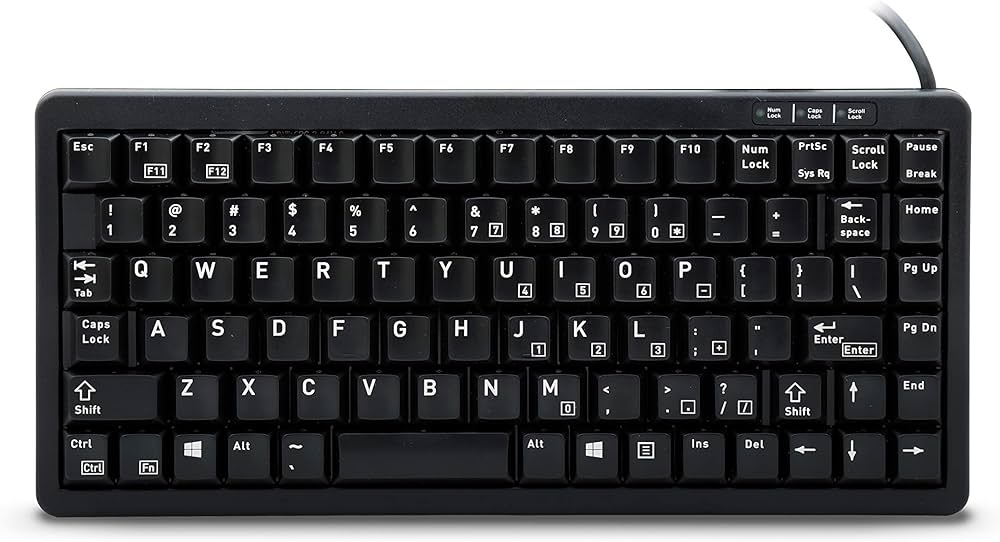
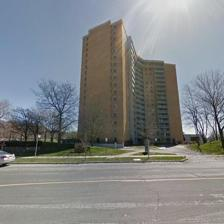
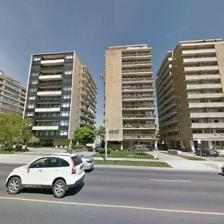
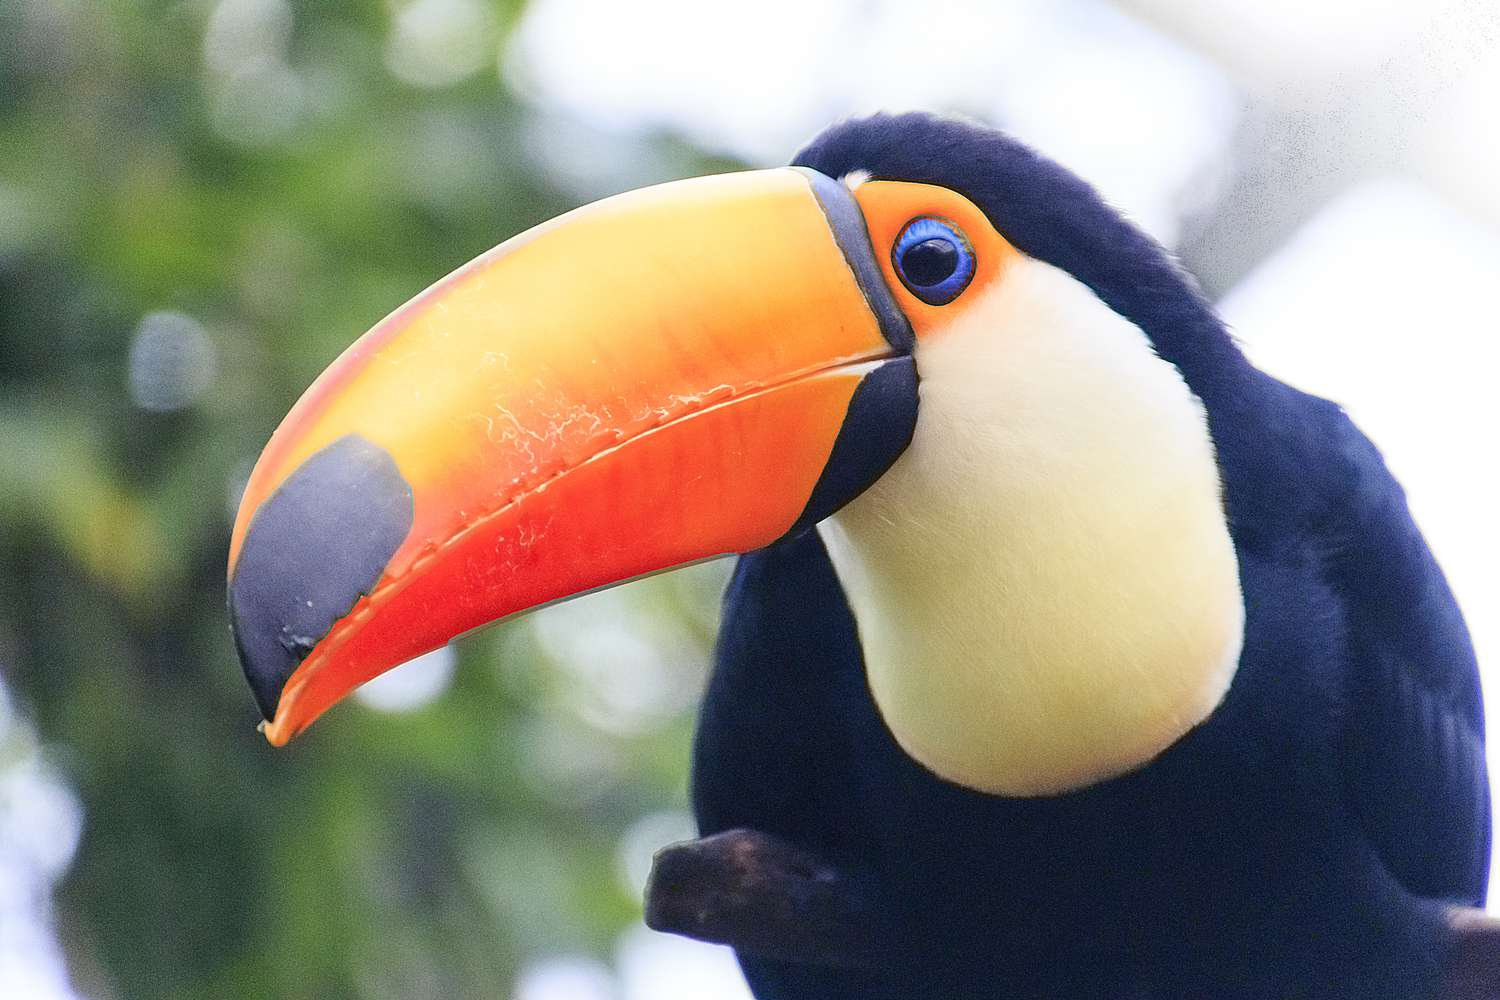
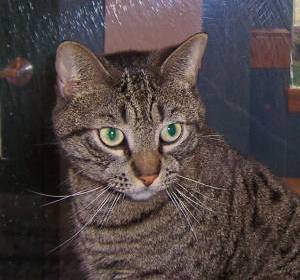
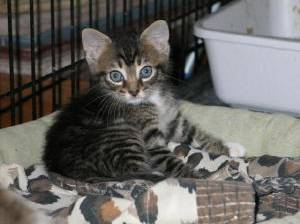
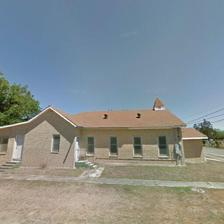

In [35]:
val html = File(imageRootDir + "/other").listFiles().sorted().take(10).joinToString("") { imaFile ->
    val inputData = fileDataLoader.load(imaFile)
    val labelIdx = originalModel.predictLabel(inputData)
    val accuracy = originalModel.predictSoftly(inputData)
    imaFile.htmlRowPrediction(labelIdx, accuracy)
}

HTML("<table>$html</table>")


,"corkscrew, bottle screw",Accuracy: 0.12405559
,comic book,Accuracy: 0.56836885
,crane,Accuracy: 0.9813038
,analog clock,Accuracy: 0.17554536
,comic book,Accuracy: 0.3722431

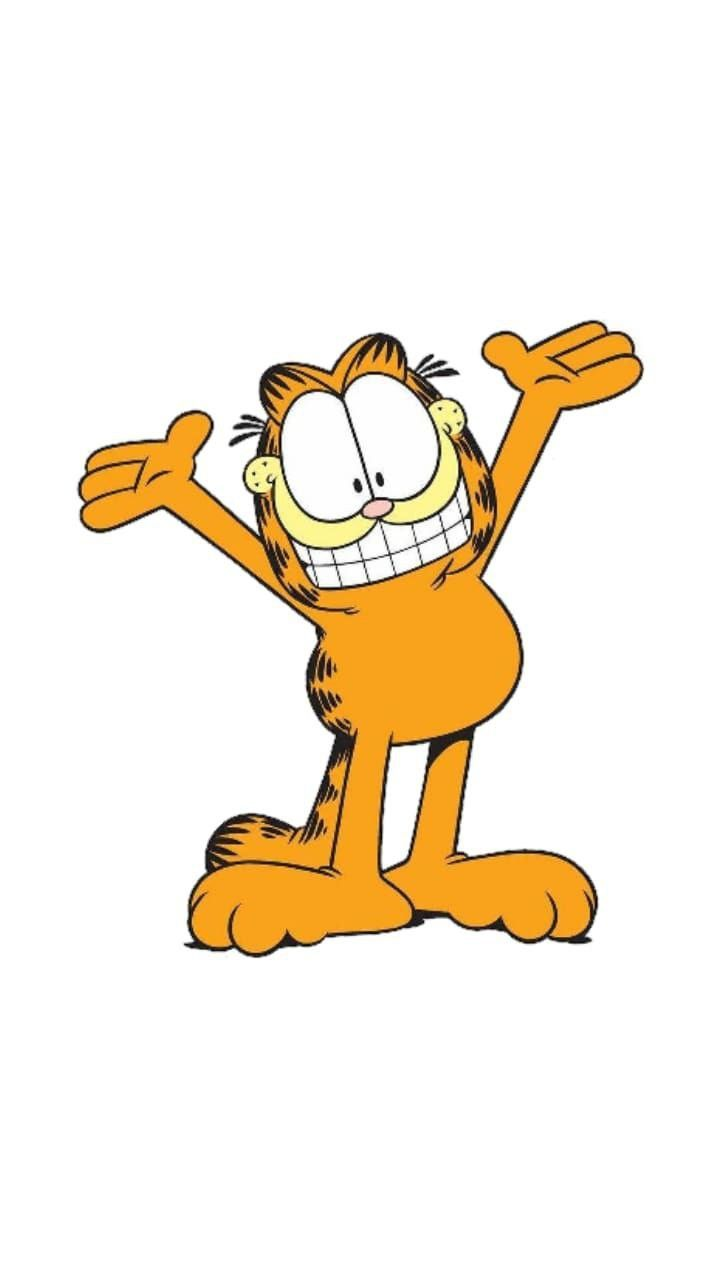
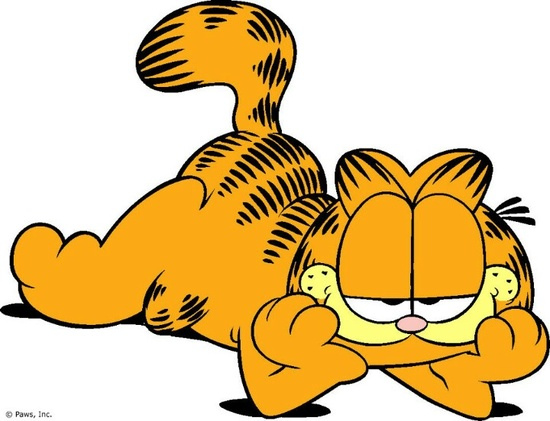
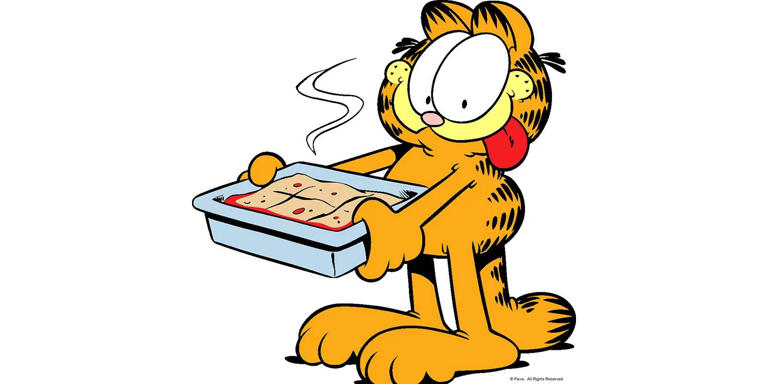
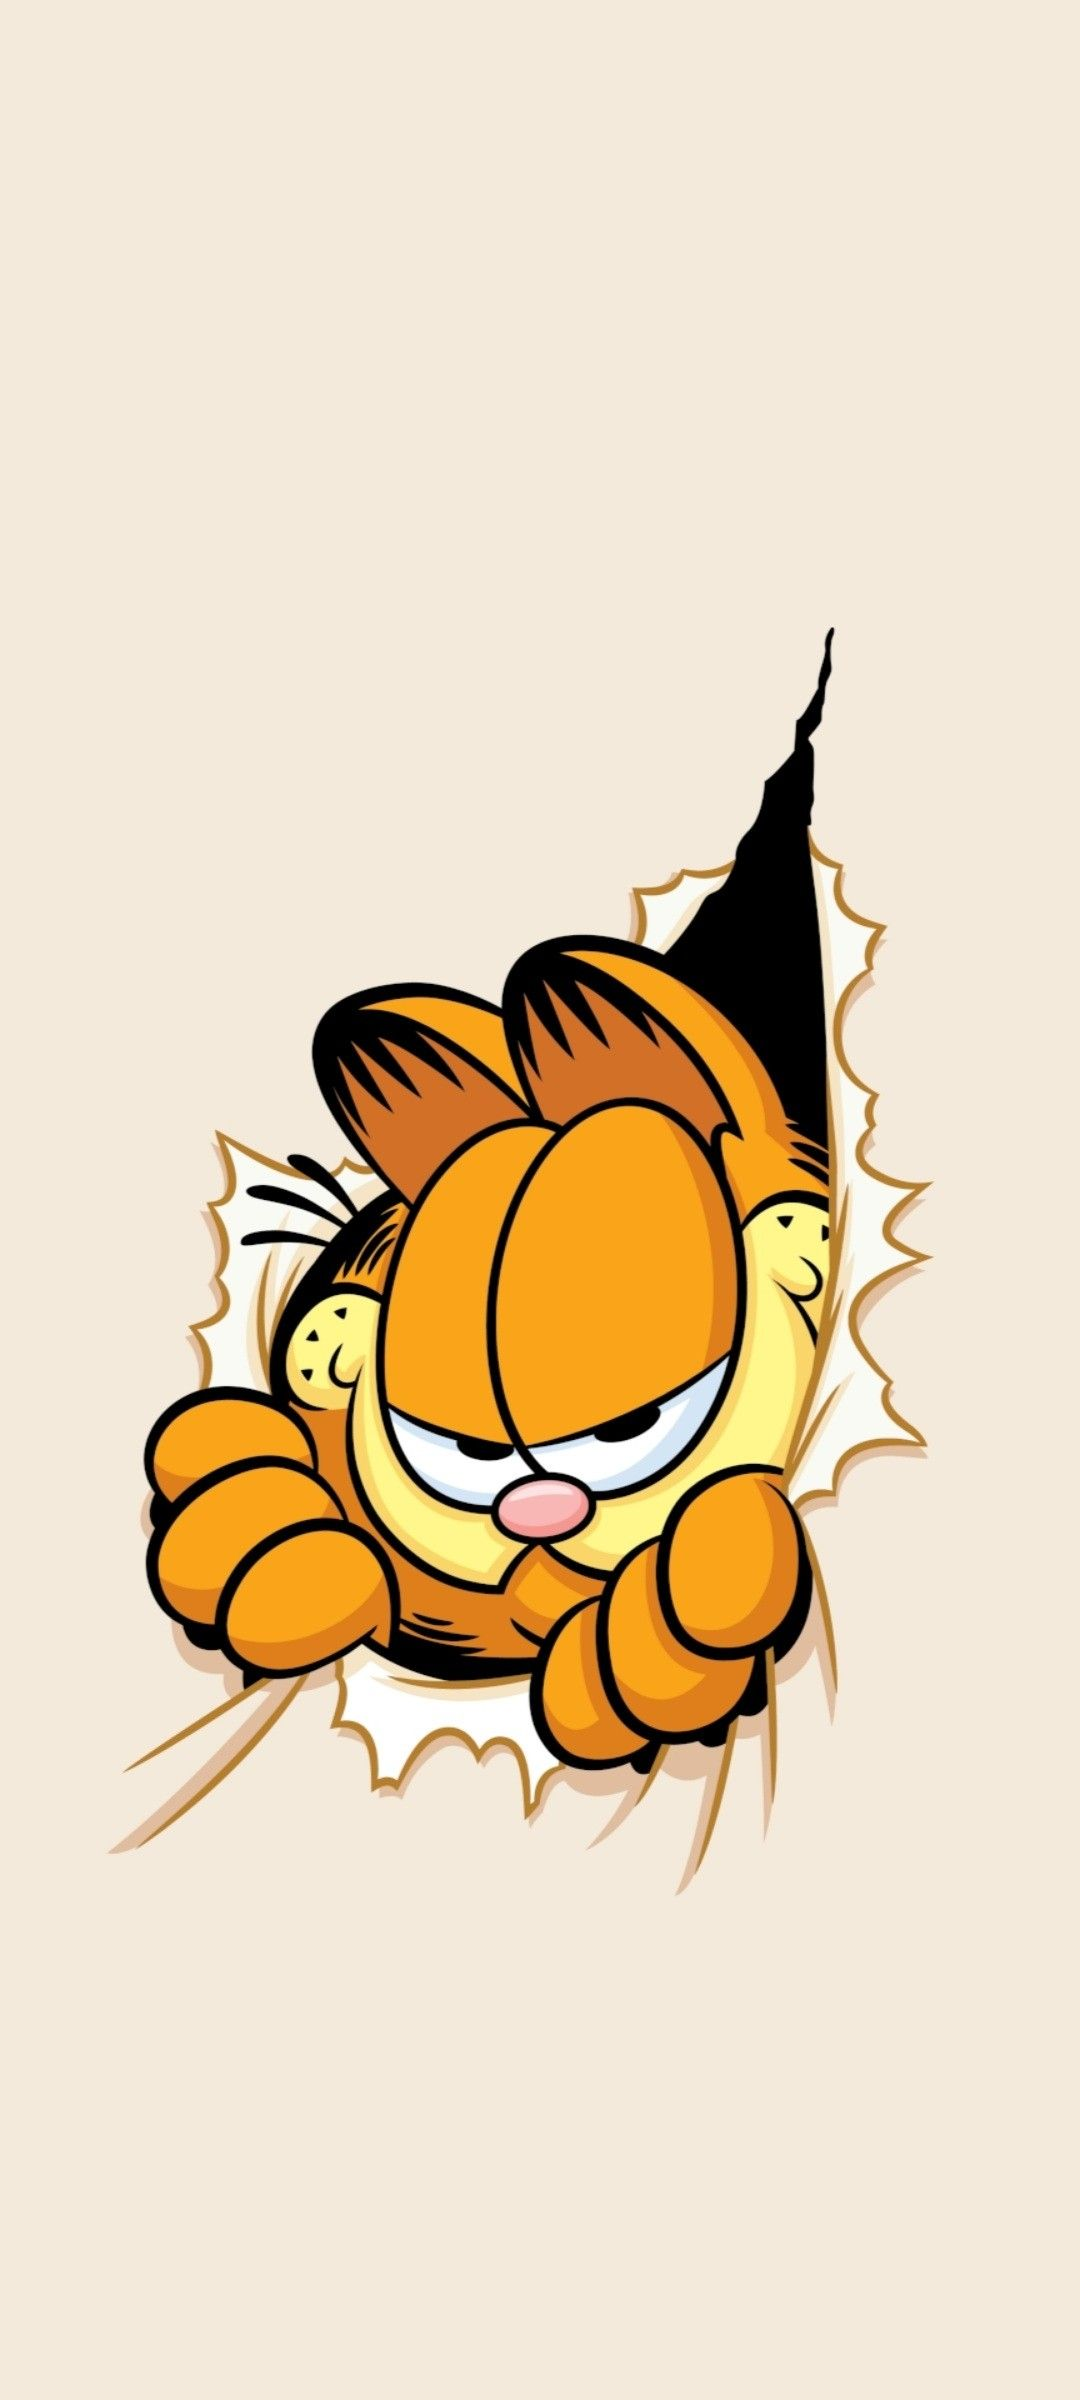
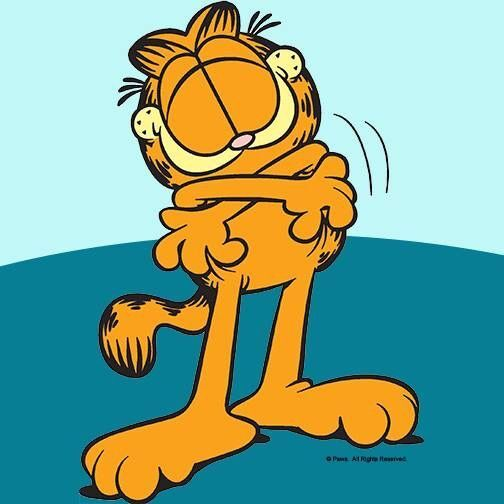

In [23]:
import java.nio.file.Files
import java.util.*

val html = File(imageRootDir + "/garfield").listFiles().take(5).joinToString("") { imaFile ->
    val inputData = fileDataLoader.load(imaFile)
    val labelIdx = originalModel.predictLabel(inputData)
    val accuracy = originalModel.predictSoftly(inputData)
    imaFile.htmlRowPrediction(labelIdx, accuracy)
}
HTML("<table>$html</table>")

In [25]:
import com.android.aaptcompiler.android.isTruthy

val modelHub = TFModelHub(cacheDirectory = File("cache/pretrainedModels"))
val modelType = TFModels.CV.MobileNetV2()
val model = modelHub.loadModel(modelType)
val hdfFile = modelHub.loadWeights(modelType)

model.use {
    it.compile(
        optimizer = Adam(),
        loss = Losses.MAE,
        metric = Metrics.ACCURACY
    )
    it.logSummary()
}

//freeze all layers
val layers = model.layers.toMutableList()
layers.forEach(Layer::freeze)

//remove last layer
val lastLayer = layers.last()
for (outboundLayer in lastLayer.inboundLayers)
    outboundLayer.outboundLayers.remove(lastLayer)
layers.removeLast()

//add new layers
var x = Dense(
    name = "top_dense",
    kernelInitializer = GlorotUniform(),
    biasInitializer = GlorotUniform(),
    outputSize = 200,
    activation = Activations.Relu
)(layers.last())

x = Dense(
    name = "pred",
    kernelInitializer = GlorotUniform(),
    biasInitializer = GlorotUniform(),
    outputSize = 2,
    activation = Activations.Linear,
)(x)

val transferedModel = Functional.fromOutput(x)

//prepare dataset
val dataset = OnHeapDataset.create(
    File(imageRootDir),
    
    FromFolders(mapping = mapOf("other" to 0, "garfield" to 1)),
    modelType.createPreprocessing(transferedModel)
).shuffle()
val (train, test) = dataset.split(TRAIN_TEST_SPLIT_RATIO)

transferedModel.use {

    //compile the model and load weights
    it.compile(
        optimizer = Adam(),
        loss = Losses.SOFT_MAX_CROSS_ENTROPY_WITH_LOGITS,
        metric = Metrics.ACCURACY
    )
    it.logSummary()
    it.loadWeightsForFrozenLayers(hdfFile)

    //check accuracy before training
    val accuracyBeforeTraining = it.evaluate(dataset = test, batchSize = TEST_BATCH_SIZE).metrics[Metrics.ACCURACY]
    println("Accuracy before training $accuracyBeforeTraining")

    //train the model
    it.fit(
        dataset = train,
        batchSize = TRAINING_BATCH_SIZE,
        epochs = EPOCHS
    )

    //check accuracy after training
    val accuracyAfterTraining = it.evaluate(dataset = test, batchSize = TEST_BATCH_SIZE).metrics[Metrics.ACCURACY]
    println("Accuracy after training $accuracyAfterTraining")

    //save the model
    val transferedModel = File("my-models/mobilenet_with_additional_training")
    it.save(
        transferedModel,
        saveOptimizerState = false,
        savingFormat = SavingFormat.JsonConfigCustomVariables(isKerasFullyCompatible = true),
        writingMode = WritingMode.OVERRIDE
    )
}





Accuracy before training 0.5
Accuracy after training 1.0


,garfield,Accuracy: 0.9999925
,garfield,Accuracy: 0.999652
,garfield,Accuracy: 0.9999857
,other,Accuracy: 1.0
,other,Accuracy: 1.0
,garfield,Accuracy: 1.0
,garfield,Accuracy: 0.99998987
,other,Accuracy: 1.0
,other,Accuracy: 1.0
,other,Accuracy: 0.99929297
,other,Accuracy: 1.0

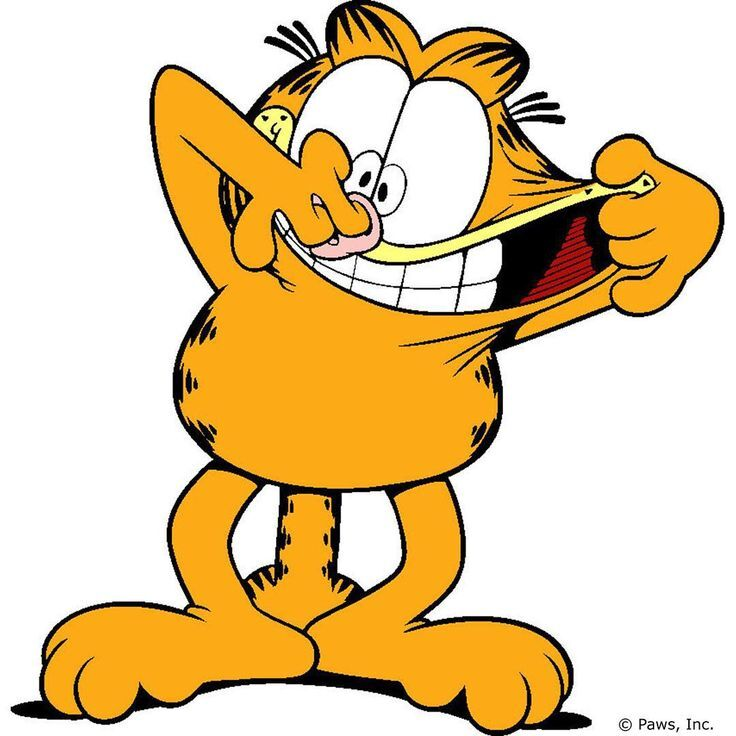
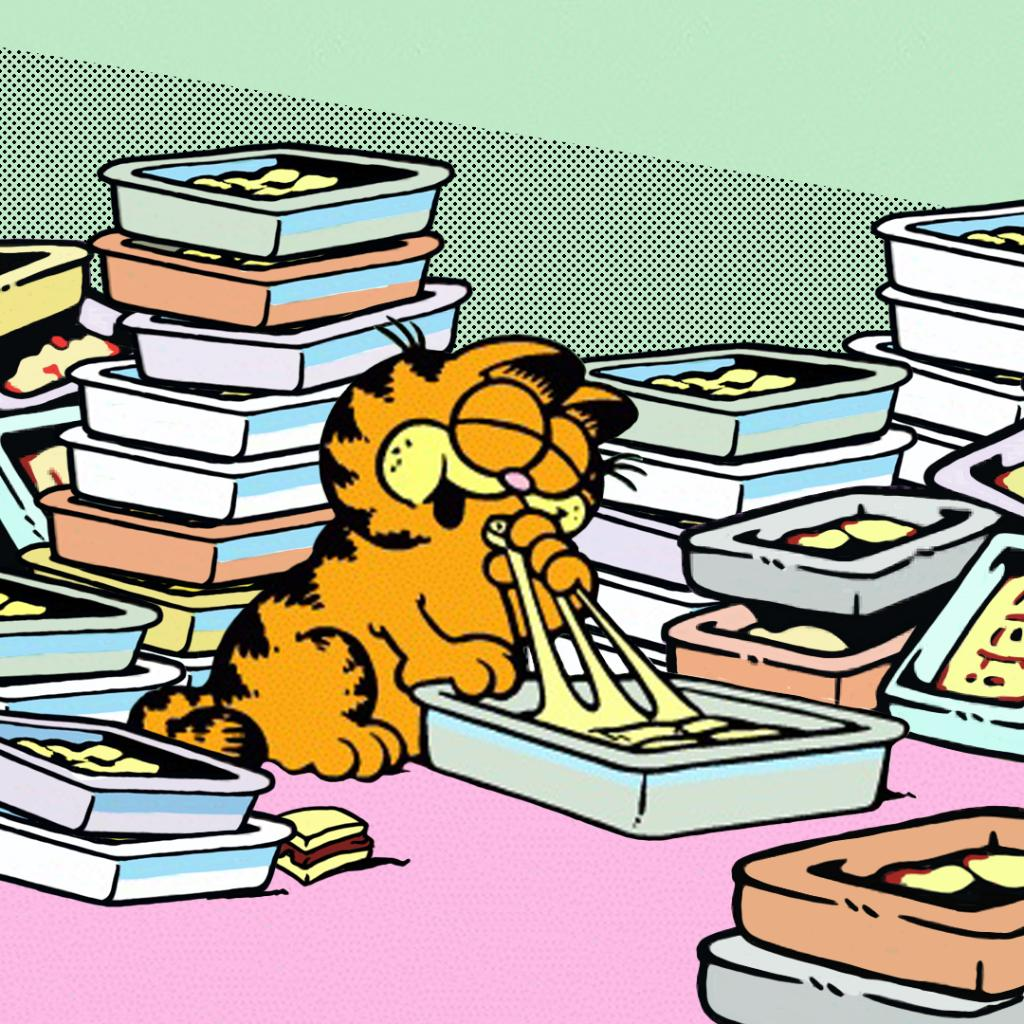
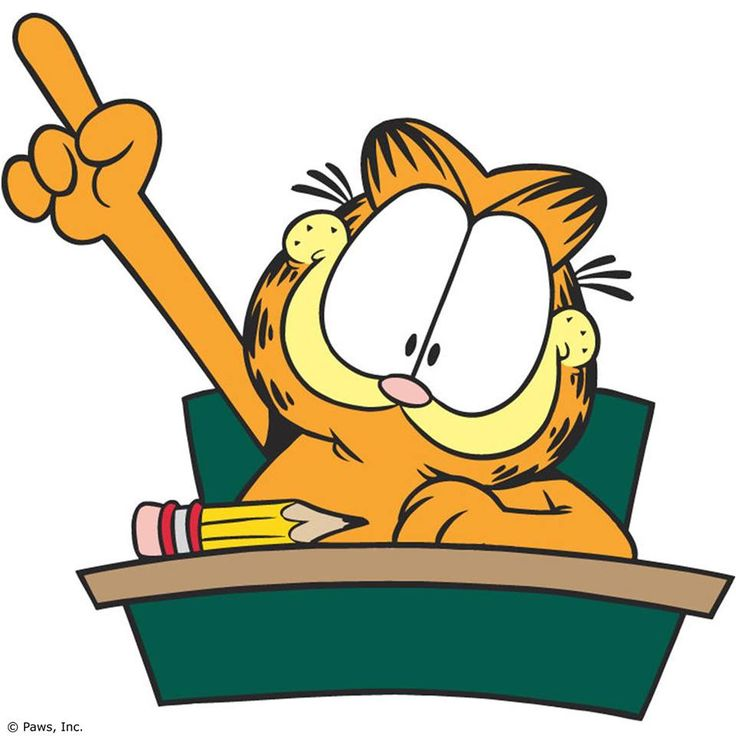
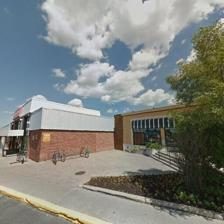
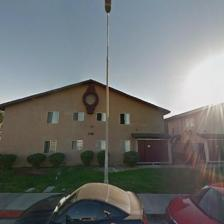
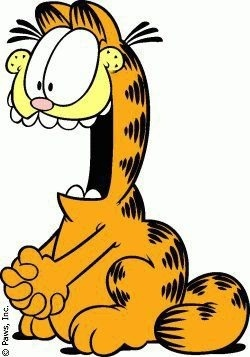
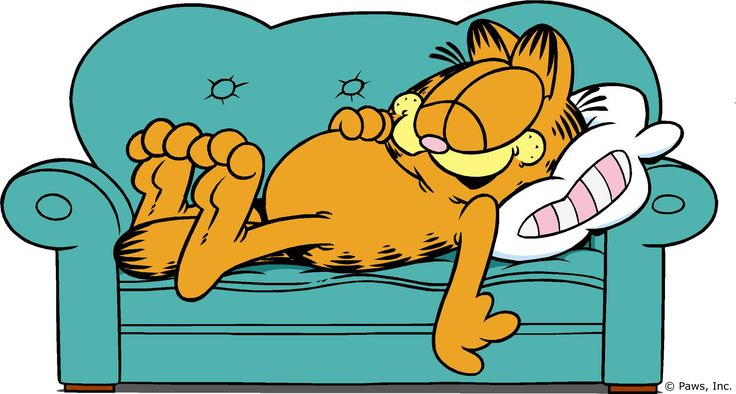
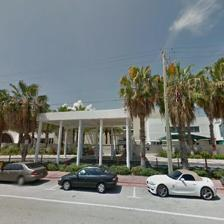
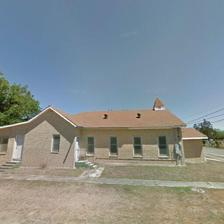
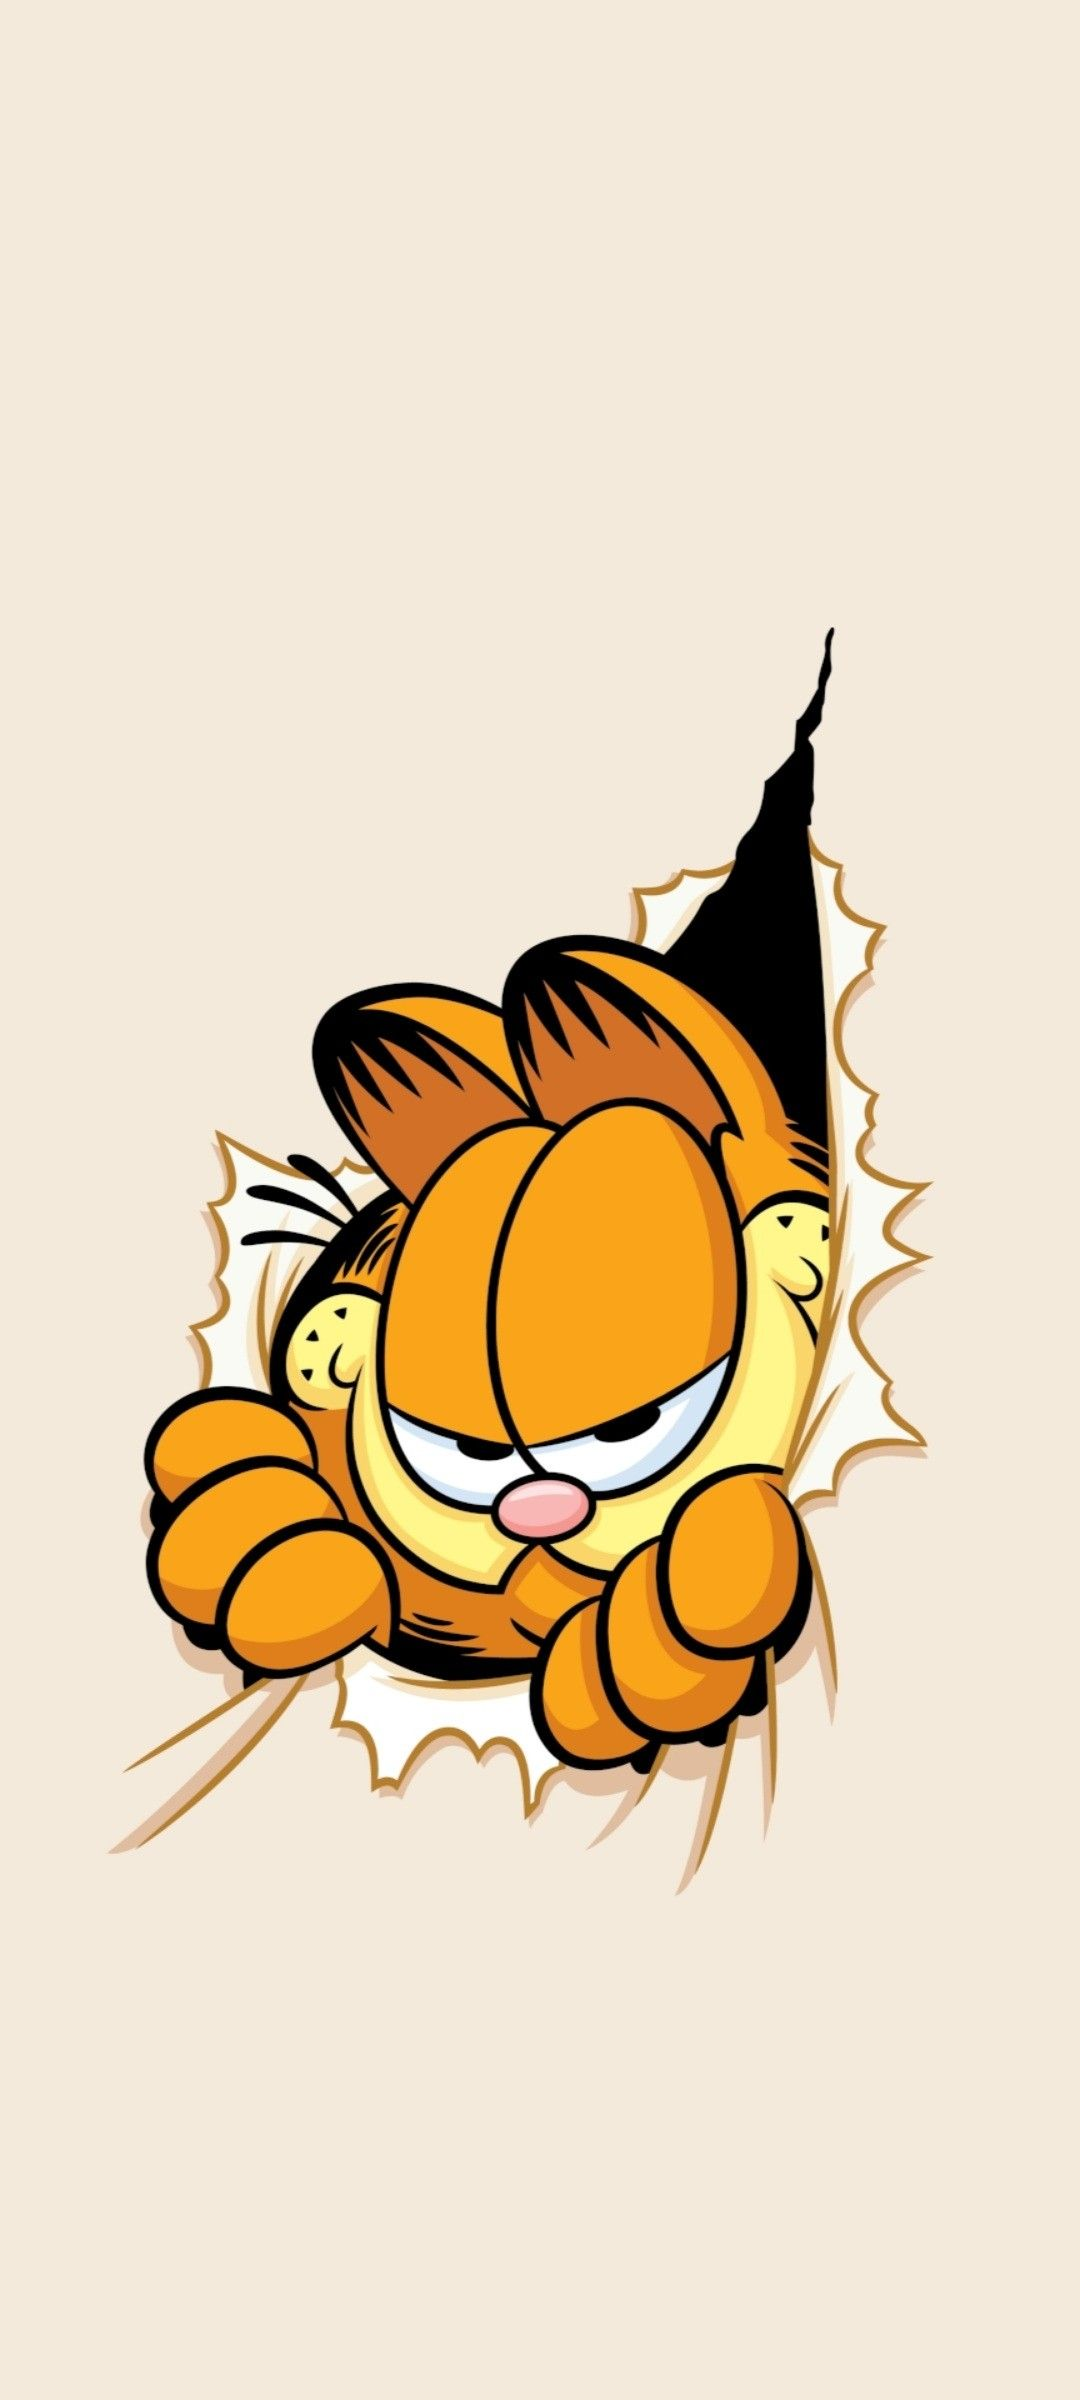
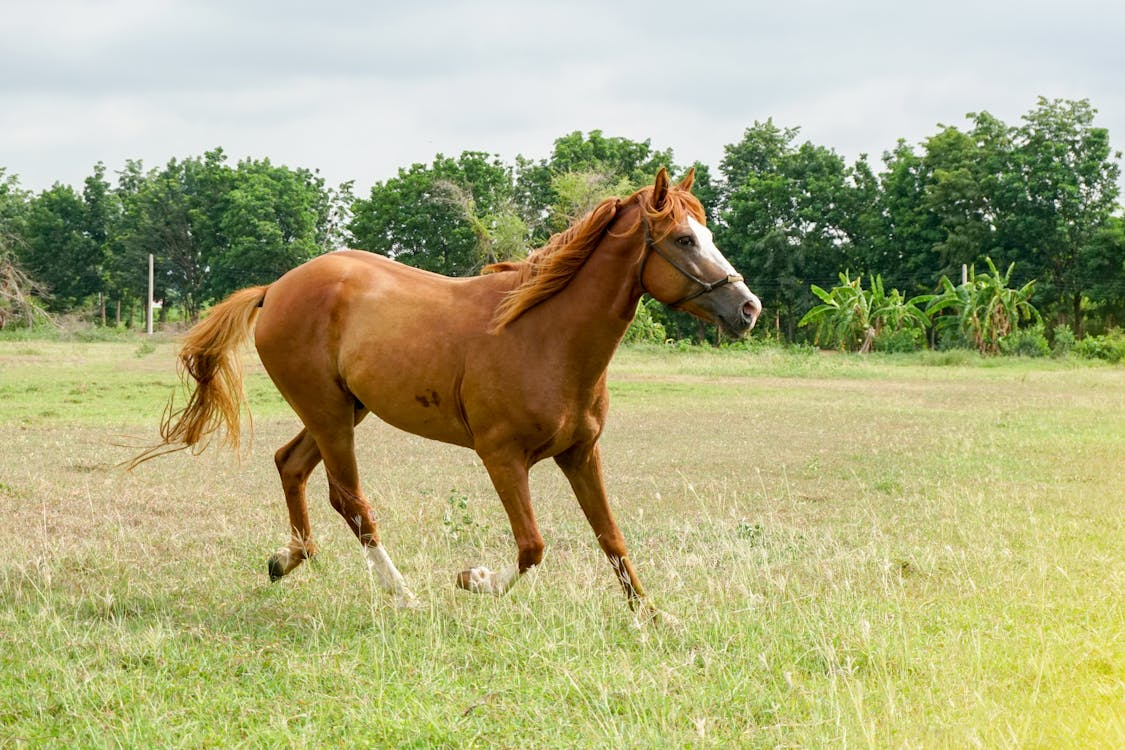
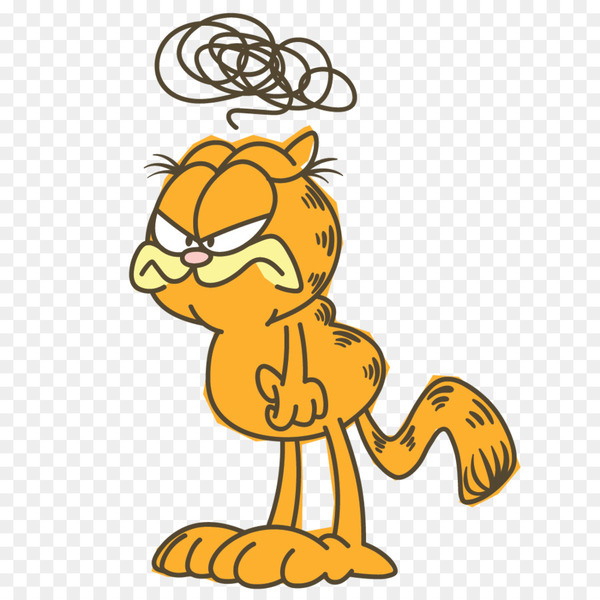
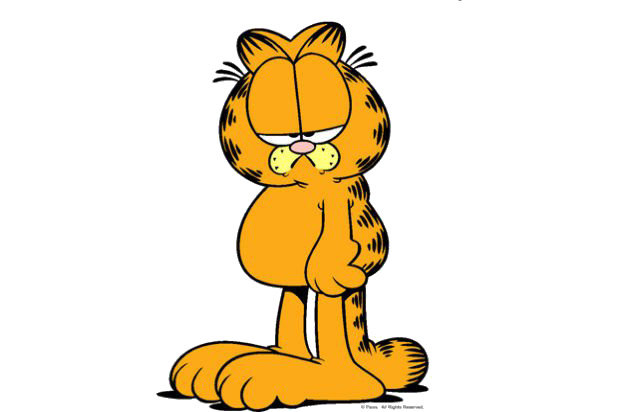
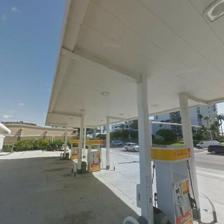
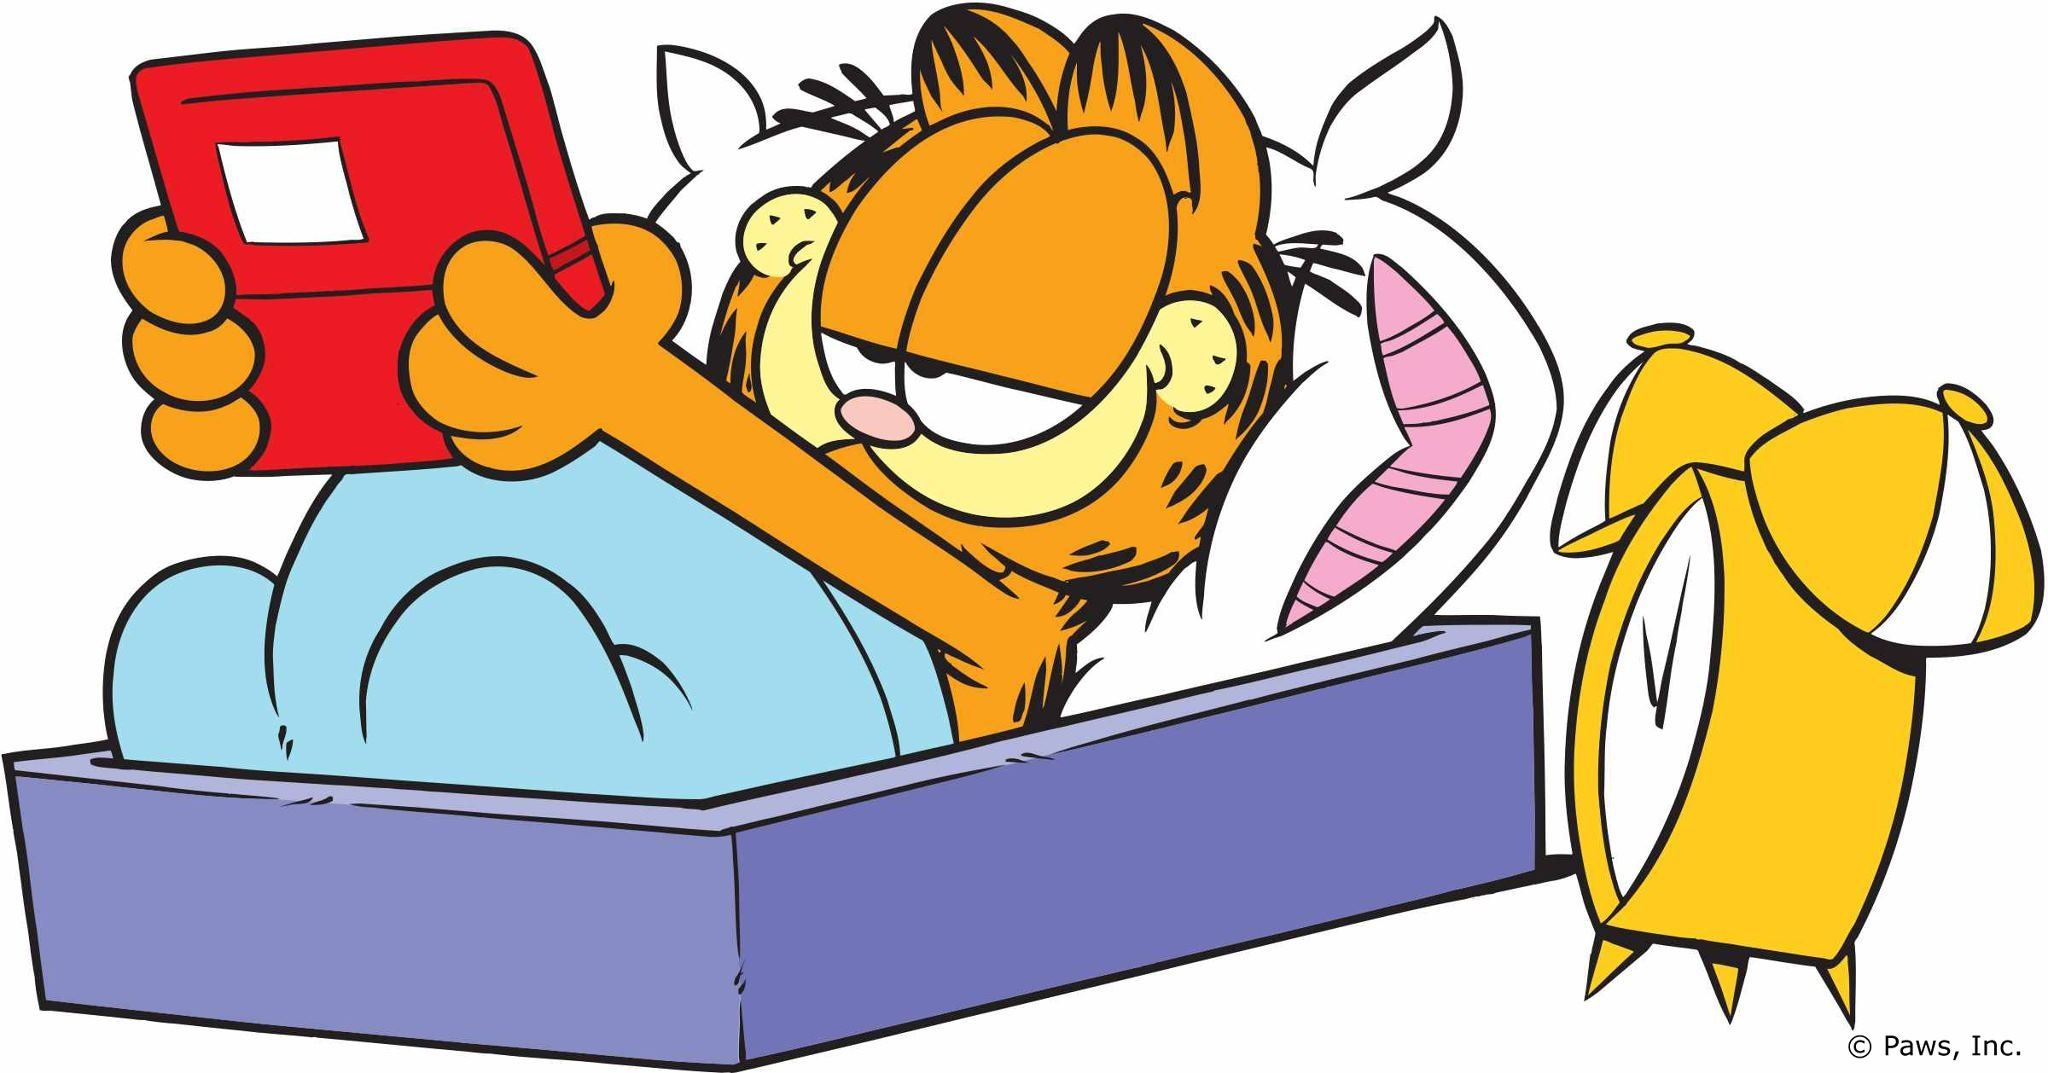
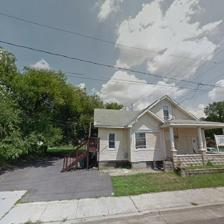
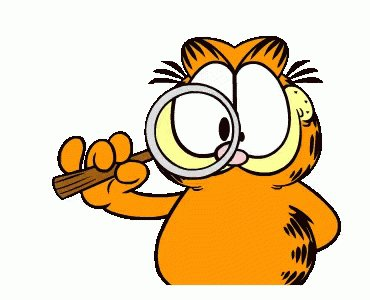
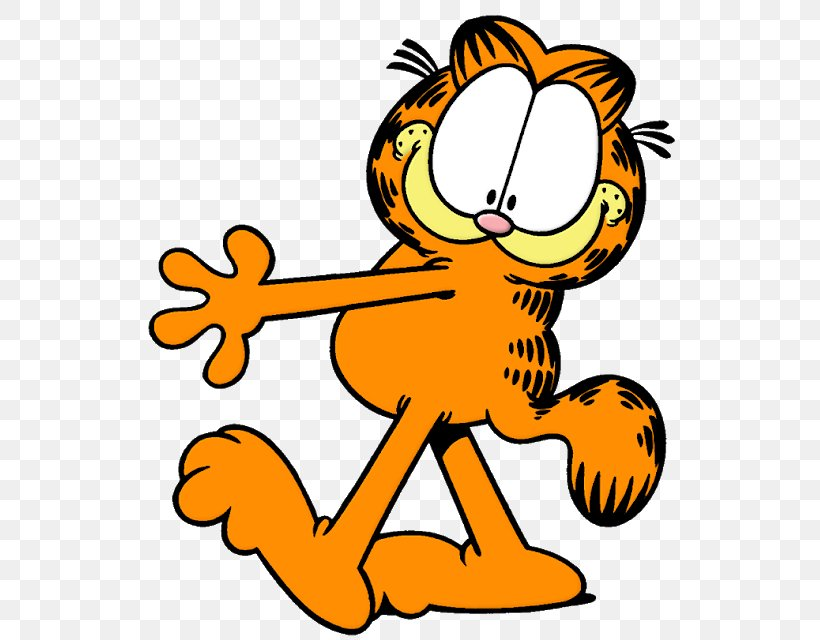
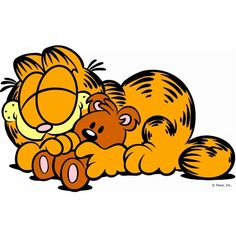
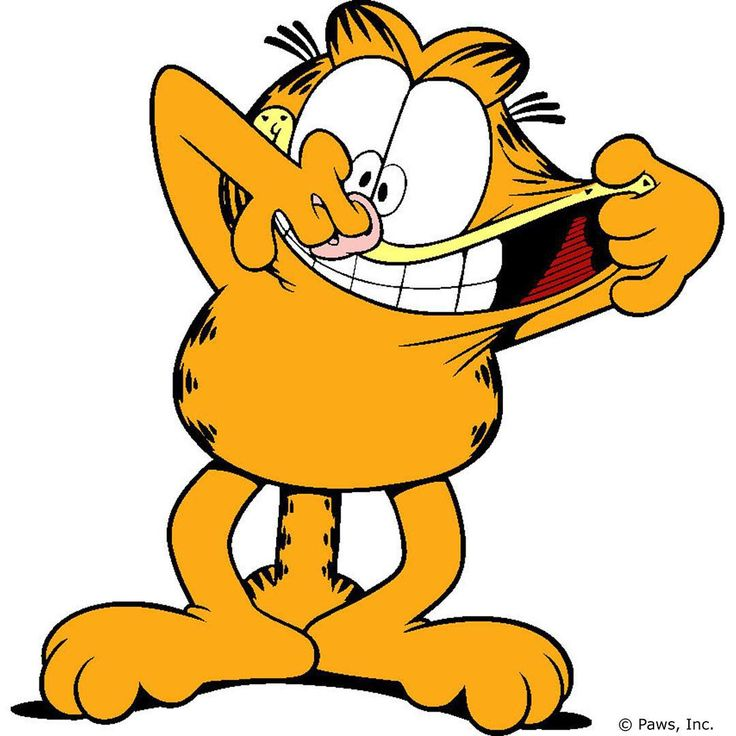

In [34]:
val newModel = Functional.loadModelConfiguration(
    File("my-models/mobilenet_with_additional_training/modelConfig.json")
)

newModel.use {
    it.compile(
        optimizer = Adam(),
        loss = Losses.SOFT_MAX_CROSS_ENTROPY_WITH_LOGITS,
        metric = Metrics.ACCURACY
    )
    it.logSummary()
    it.loadWeights(File("my-models/mobilenet_with_additional_training"))

    val html = listOf("other", "garfield").flatMap { 
            File("$imageRootDir/$it").listFiles().toList()
        }.shuffled()
        .take(20).joinToString("")  { imaFile ->
            val inputData = fileDataLoader.load(imaFile)
            val labelIdx = it.predictLabel(inputData)
            val accuracy = it.predictSoftly(inputData)
            imaFile.htmlRowPrediction(labelIdx, accuracy, 
                labels = mapOf(0 to "other", 1 to "garfield"))
    }
    HTML("<table>$html</table>")
}